# Cloud masks for Sentinel-2

## Visual assessment
## impact on Geomedian

From disk:
* MAJA (CNES), temporal
* FMASK
* TSMASK (Peter), temporal
* s2cloudmask-spectral (Dale) - no shadow
* s2cloudmask-temporal (Dale)

Calculated on the fly:
* L1C three-band (Fang) - no shadow

In [116]:
%matplotlib inline
import datacube
from datacube.storage import masking

import yaml
import xarray as xr
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import gridspec

from scipy import ndimage
from skimage.morphology import disk
from skimage.filters import rank

In [3]:
def stretch_RGB(data, l=None, h=None):
    tmp=data.astype(np.float32)
    #tmp[data<=0]=np.nan
    if l is None: l = np.nanpercentile(tmp,1)
    if h is None: h = np.nanpercentile(tmp,99.5)
    a = (tmp-l)/(h-l)*255 
    a[a>255]=255
    a[a<0]=0
    return a, l, h

def RGB_plot(da, rl=None, rh=None, gl=None, gh=None, bl=None, bh=None):      
    rgbArray = np.zeros_like(da.values, 'uint8')
    rgbArray[0], rl, rh = (stretch_RGB(da.values[0], rl, rh))
    rgbArray[1], gl, gh = (stretch_RGB(da.values[1], gl, gh))
    rgbArray[2], bl, bh = (stretch_RGB(da.values[2], bl, bh))
    return rgbArray.transpose(1,2,0), rl, rh, gl, gh, bl, bh

# Connect to test datacube and production datacube

In [4]:
!cat cloudtest.conf

[datacube]
db_hostname: agdcdev-db.nci.org.au
db_port: 6432
db_database: emma_test
[fmask]
db_hostname: agdcdev-db.nci.org.au
db_port: 6432
db_database: s2fmask


In [5]:
dc = datacube.Datacube(config='cloudtest.conf')
prod_dc = datacube.Datacube()
fmask_dc = datacube.Datacube(config='cloudtest.conf', env='fmask')

## Only center S2 granules are inspected

This helps to reduce the number of images to inspect and align nbart, maja and s2cloud mask input images

In [6]:
granule_of_interest = ['T55HCU', 'T56HLH', 'T55GDP', 'T54HTG', 'T52KDA', 'T50HMG']

## Spectral bands used for true-color and false-color inspections

In [199]:
#l1c_band_names = {'B02':'blue','B03':'green','B04':'red','B08':'nir','B10':'cirrus','B11':'swir1'}
l1c_band_names = {'B8A':'nir', 'B09':'vapour','B10':'cirrus'}
l1c_band_of_interest = l1c_band_names.keys()
nbart_band_names = {'nbart_blue':'blue','nbart_green':'green','nbart_red':'red',
                    'nbart_nir_1':'nir', 'nbart_swir_2':'swir1'}
nbart_band_of_interest = list(nbart_band_names.keys()) +['fmask']

true_rgb = ['red','green','blue']
false_rgb = ['swir1','nir','green']

# Define area of interest

In [225]:
# Tasmania
x, y = (1209000, 1219000), (-4630000, -4620000)
# Melbourne
#x, y = (1133000, 1143000), (-4195000, -4185000)
# South Sydney
#x, y = (1746000, 1756000), (-3852000, -3842000)

query = {'x': x, 'y':y, 'resolution':(20,20),
         'crs': 'EPSG:3577', 'output_crs':'EPSG:3577',
        'time': ('2016-07-01','2017-07-01')}

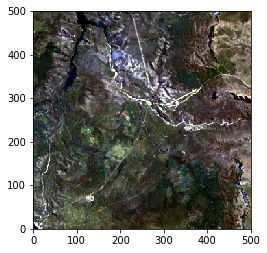

In [226]:
# use geomedian as reference to set proper rgb range
gm_dss= prod_dc.find_datasets(product='ls8_nbart_geomedian_annual', **query)
gm = prod_dc.load(product='ls8_nbart_geomedian_annual', datasets = [gm_dss[0]],**query).isel(time=0)

true_img = RGB_plot(gm[true_rgb].to_array())
false_img = RGB_plot(gm[false_rgb].to_array())
p=plt.imshow(true_img[0],origin='lower')

# Load MAJA masks

In [227]:
dss = dc.find_datasets(product='maja_cloud_geo_mask', **query)
len(dss)

64

In [228]:
maja_dss = []
granules = granule_of_interest
for ds in dss:
    doc=yaml.load(open(ds.local_path))
    if doc['lineage']['source_datasets']['0']['image']['tile_reference'] in granules:
        granules = [doc['lineage']['source_datasets']['0']['image']['tile_reference']]
        maja_dss.append(ds)
    else:
        continue
        #print(doc['lineage']['source_datasets']['0']['image']['tile_reference'])

granule_name = granules[0]
print(len(maja_dss),granule_name)

31 T55GDP


In [229]:
maja_mask = dc.load(product='maja_cloud_geo_mask', datasets= maja_dss, group_by='solar_day', **query)

## Find corresponding NBART data and L1C data

In [230]:
source_dss = {}
l1c_dss = {}
for ds in maja_dss:
    doc = yaml.load(open(ds.local_path))
    l1c_ds = prod_dc.index.datasets.get(doc['lineage']['source_datasets']['0']['id'])
    derived = prod_dc.index.datasets.get_derived(l1c_ds.id)
    if len(derived)==1:
        if derived[0].type.name in source_dss.keys():
            source_dss[derived[0].type.name].append(derived[0])
            l1c_dss[l1c_ds.type.name].append(l1c_ds)
        else:
            source_dss[derived[0].type.name]=[derived[0]]
            l1c_dss[l1c_ds.type.name]=[l1c_ds]
    elif len(derived)>1:
        print(derived)

In [231]:
source_dss.keys()

dict_keys(['s2a_ard_granule'])

In [232]:
source_data = None
for product, datasets in source_dss.items():
    source_data = prod_dc.load(product=product, measurements=nbart_band_of_interest,
                           datasets=datasets, group_by='solar_day', **query)
        
source_data=source_data.rename(nbart_band_names)
#source_data

l1c_data = None
for product, datasets in l1c_dss.items():
    l1c_data = prod_dc.load(product=product, measurements=l1c_band_of_interest,
                           datasets=datasets, group_by='solar_day', **query)
        
l1c_data=l1c_data.rename(l1c_band_names)

## L1C cloud mask

1. Construct cirrus band (B10) reference (cirrus_ref) as 0.05 quantile in a time series. Using minimum reflectance is a much faster alternative but is less robust.
2. Use ratio of B09(water vapour) over B8A (NIR) to constrain total column water vapour and to determine B10/cirrus_ref threshold.
3. If minimum reflectance is used as reference, threshold = B09/B8A *2. + 1.5; if 0.05 quantile is used, threshold = B09/B8A *2 + 1.3

In [233]:
%%time
#cirrus_ref = l1c_data.cirrus.min(dim='time')
cirrus_ref = l1c_data.cirrus.quantile(0.05, dim='time')

CPU times: user 44.5 s, sys: 24 ms, total: 44.6 s
Wall time: 44.5 s


CPU times: user 198 ms, sys: 1 ms, total: 199 ms
Wall time: 197 ms


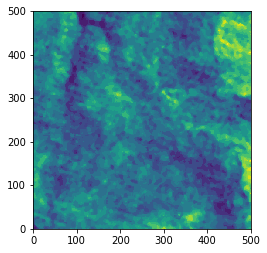

In [234]:
%%time
cirrus_ref_smooth = ndimage.median_filter(cirrus_ref, footprint=disk(5))
plt.imshow(cirrus_ref_smooth, origin='lower')

In [235]:
%%time
# spatially smooth the water vapour content map 
# can probably speed up with downsampling first
threshold = (l1c_data.vapour/l1c_data.nir).groupby('time').apply(
    lambda x: ndimage.uniform_filter(x, size=300))*2.+1.3
# smoothed 
cirrus_mask = (l1c_data.cirrus/cirrus_ref_smooth).groupby('time').apply(
    lambda x: ndimage.median_filter(x, footprint=disk(5))) > threshold

CPU times: user 6.7 s, sys: 1.79 s, total: 8.49 s
Wall time: 8.41 s


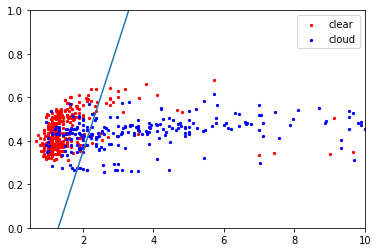

In [236]:
arr1 = (l1c_data.cirrus/cirrus_ref_smooth).groupby('time').apply(lambda x: ndimage.median_filter(x, size=5)).isel(
    x=slice(0,500,100), y =slice(0,500,100)).values.ravel()
arr2 = (l1c_data.vapour/l1c_data.nir).groupby('time').apply(lambda x: ndimage.uniform_filter(x, size=300)).isel(
    x=slice(0,500,100), y =slice(0,500,100)).values.ravel()
cloud = masking.make_mask(maja_mask.sel(time=l1c_data.time).geo_mask, cloud_not_thinnest = True).isel(
    x=slice(0,500,100), y =slice(0,500,100)).values.ravel()
#make sure threshold looks reasonable
plt.scatter(arr1[~cloud], arr2[~cloud], color='r', label='clear', s=5)
plt.scatter(arr1[cloud], arr2[cloud], color='b', label='cloud', s=5)
plt.legend()
plt.xlim((0.5,10))
plt.ylim((0,1))
plt.plot(np.array([0,1])*2.+1.3,[0,1])

# New Fmask

In [237]:
fmask_dss = fmask_dc.find_datasets(product='fmask_s2a', **query)

fmask = fmask_dc.load(product='fmask_s2a', datasets=fmask_dss, group_by='solar_day', **query)

# TSMASK

In [238]:
ts_dss = dc.find_datasets(product='ts_cloud_mask',product_type='ts_cloud_mask_v1.1', **query)
tsmask = dc.load(product='ts_cloud_mask', datasets=ts_dss, group_by='solar_day',**query)

# s2cloudmask

In [239]:
dss = dc.find_datasets(product='s2_cloud_shadow_mask_temporal', **query)

s2cloud_dss= []
for ds in dss:
    if str(ds.local_path).split('/')[-1].split('_')[8] in granules:
        s2cloud_dss.append(ds)

s2cloud = dc.load(product='s2_cloud_shadow_mask_temporal', datasets = s2cloud_dss, group_by='solar_day', **query)

In [240]:
#dss = dc.find_datasets(product='s2_cloud_mask_spectral', **query)
#s2cloud = dc.load(product='s2_cloud_mask_spectral', datasets = dss,**query)

# Visual check of masks

In [241]:
s2cloud, maja_mask, tsmask, source_data, cirrus_mask, l1c_data = xr.align(s2cloud, maja_mask, tsmask, source_data, 
                                                                          cirrus_mask, l1c_data,
                                                                join='inner')

cloud_mask = masking.make_mask(maja_mask.geo_mask, cloud_not_thinnest = True)
shadow_mask = masking.make_mask(maja_mask.geo_mask, shadow_all = True)
tsmask_cloud = (tsmask.cloud_mask == 3)
tsmask_shadow = (tsmask.cloud_mask == 2)
s2cloud_cloud = masking.make_mask(s2cloud.cloud_shadow_mask, cloud = True)
s2cloud_shadow = masking.make_mask(s2cloud.cloud_shadow_mask, shadow = True)

In [242]:
#from skimage.morphology import binary_erosion, binary_dilation, disk
#cirrus_mask_buffered=cirrus_mask.groupby('time').apply(lambda x: binary_dilation(binary_erosion(x, disk(3)), disk(6)))

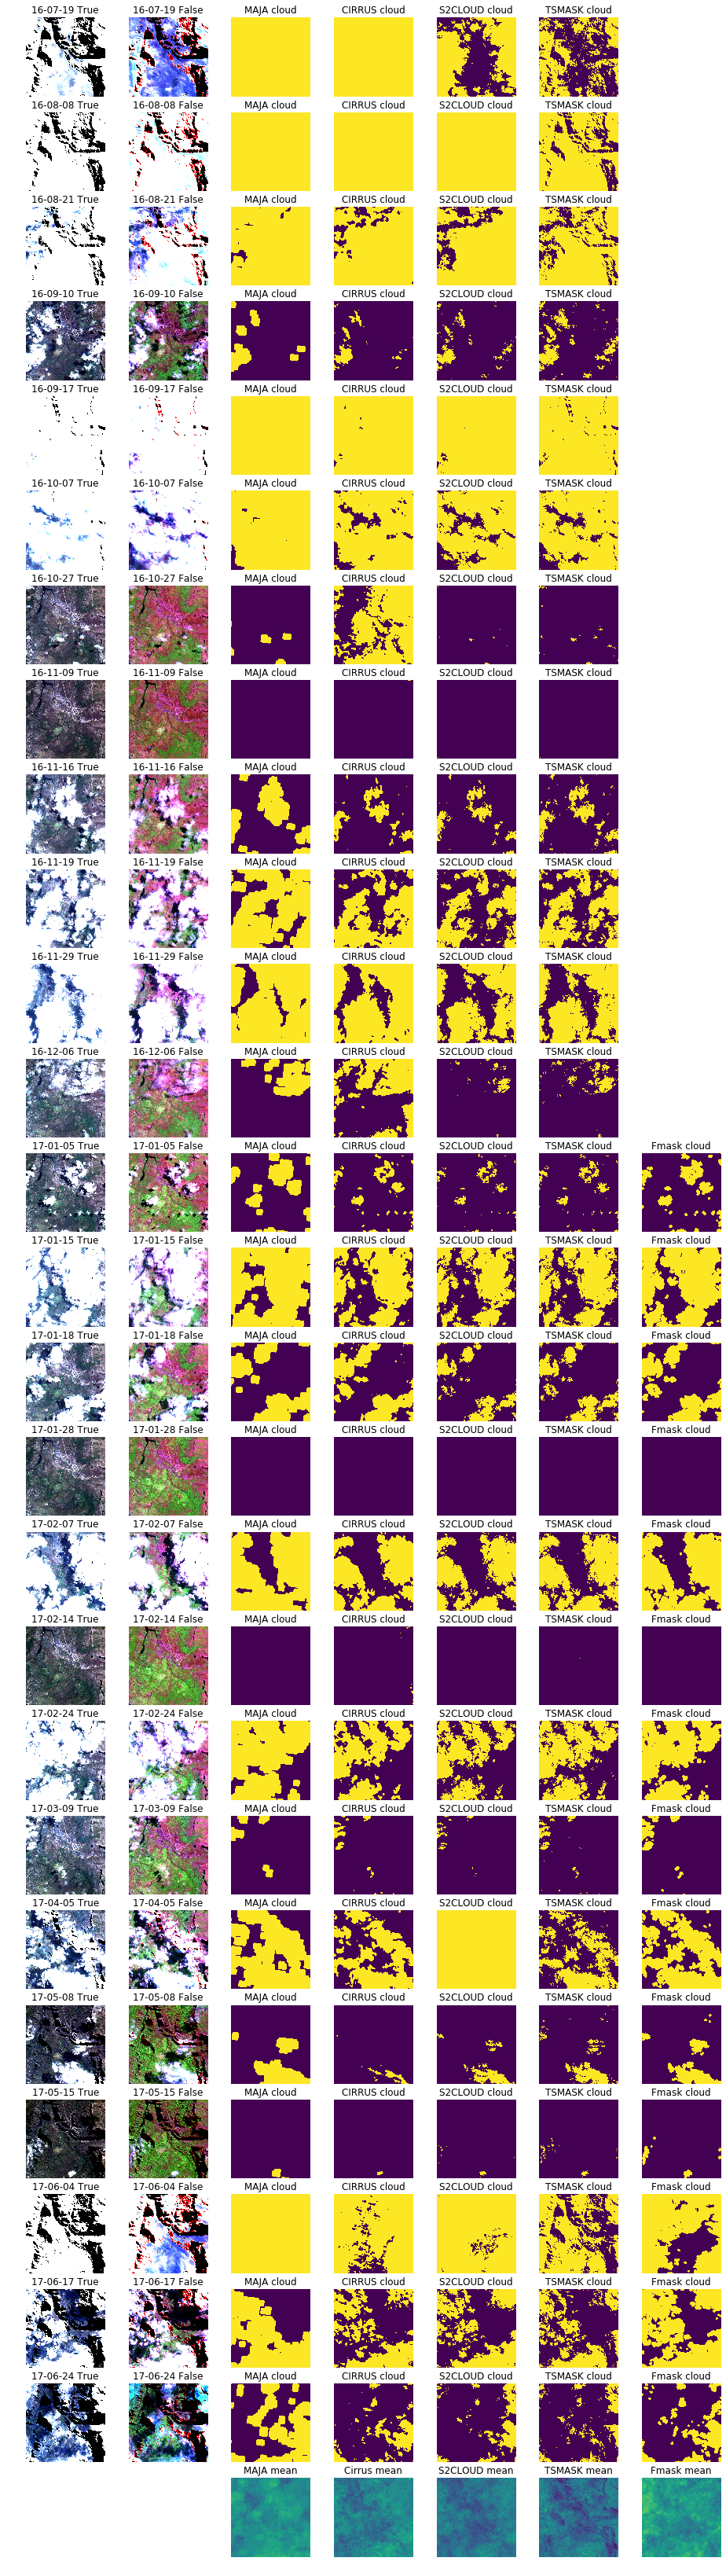

In [243]:
# cloud
nrow = len(source_data.time.values)
ncol= 7 # true, false, MAJA, cirrus, s2cloud, tsmask, fmask

f = plt.figure(figsize=(16,16/ncol*nrow))
gs = gridspec.GridSpec(nrow+1, ncol, figure=f)

for i in range(nrow):
    t = source_data.time.values[i]
    
    ax = f.add_subplot(gs[i,0])
    ax.axis('off')
    ax.set_title(str(t)[2:10]+ " True")
    ax.imshow(RGB_plot(source_data.isel(time=i)[true_rgb].to_array(),*true_img[1:])[0],origin='lower')
    
    ax = f.add_subplot(gs[i,1])
    ax.axis('off')
    ax.set_title(str(t)[2:10]+ " False")
    ax.imshow(RGB_plot(source_data.isel(time=i)[false_rgb].to_array(),*false_img[1:])[0],origin='lower')

    ax = f.add_subplot(gs[i,2])
    ax.axis('off')
    ax.set_title("MAJA cloud")
    ax.imshow(cloud_mask.isel(time=i),origin='lower', vmin=0, vmax=1)

    ax = f.add_subplot(gs[i,3])
    ax.axis('off')
    ax.set_title("CIRRUS cloud")
    ax.imshow(cirrus_mask.isel(time=i),origin='lower', vmin=0, vmax=1)

    ax = f.add_subplot(gs[i,4])
    ax.axis('off')
    ax.set_title("S2CLOUD cloud")
    ax.imshow(s2cloud_cloud.isel(time=i),origin='lower', vmin=0, vmax=1)

    ax = f.add_subplot(gs[i,5])
    ax.axis('off')
    ax.set_title("TSMASK cloud")
    ax.imshow(tsmask_cloud.isel(time=i),origin='lower', vmin=0, vmax=1)

    if t in fmask.time.values:
        ax = f.add_subplot(gs[i,6])
        ax.axis('off')
        ax.set_title("Fmask cloud")
        ax.imshow(fmask.sel(time=t).fmask==2,origin='lower', vmin=0, vmax=1)

i+=1
ax = f.add_subplot(gs[i,2])
ax.axis('off')
ax.set_title("MAJA mean")
ax.imshow(cloud_mask.mean(dim='time',skipna=True),origin='lower', vmin=0, vmax=1, cmap='viridis')

ax = f.add_subplot(gs[i,3])
ax.axis('off')
ax.set_title("Cirrus mean")
ax.imshow(cirrus_mask.mean(dim='time', skipna= True),origin='lower', vmin=0, vmax=1, cmap='viridis')

ax = f.add_subplot(gs[i,4])
ax.axis('off')
ax.set_title("S2CLOUD mean")
ax.imshow(s2cloud_cloud.mean(dim='time', skipna= True),origin='lower', vmin=0, vmax=1, cmap='viridis')

ax = f.add_subplot(gs[i,5])
ax.axis('off')
ax.set_title("TSMASK mean")
ax.imshow(tsmask_cloud.mean(dim='time', skipna= True),origin='lower', vmin=0, vmax=1, cmap='viridis')

ax = f.add_subplot(gs[i,6])
ax.axis('off')
ax.set_title("Fmask mean")
ax.imshow((fmask.fmask==2).mean(dim='time', skipna= True),origin='lower', vmin=0, vmax=1, cmap='viridis')

f.savefig('stamps/cloud_stamps_%d_%d_%d_%d_cirrus.png'%(x[0], x[1], y[0], y[1]))

# Geomedian output

In [261]:
from pcm import gmpcm as geometric_median

median_image_tsmask = xr.DataArray(geometric_median(source_data.where(~tsmask_cloud)[list(nbart_band_names.values())].to_array(dim='band').transpose('y','x','band','time').data.astype(np.float32)),
            coords={'y':source_data.y,'x':source_data.x,'band':list(nbart_band_names.values())},
            dims=['y','x','band'], attrs={'name':'Geomedian tsmask'}).to_dataset(dim='band')
median_image_cirrus = xr.DataArray(geometric_median(source_data.where(~cirrus_mask)[list(nbart_band_names.values())].to_array(dim='band').transpose('y','x','band','time').data.astype(np.float32)),
            coords={'y':source_data.y,'x':source_data.x,'band':list(nbart_band_names.values())},
            dims=['y','x','band'], attrs={'name':'Geomedian cirrus'}).to_dataset(dim='band')
median_image_s2cloud = xr.DataArray(geometric_median(source_data.where(~s2cloud_cloud)[list(nbart_band_names.values())].to_array(dim='band').transpose('y','x','band','time').data.astype(np.float32)),
            coords={'y':source_data.y,'x':source_data.x,'band':list(nbart_band_names.values())},
            dims=['y','x','band'], attrs={'name':'Geomedian s2cloud'}).to_dataset(dim='band')

median_image_maja = xr.DataArray(geometric_median(source_data.where(~cloud_mask)[list(nbart_band_names.values())].to_array(dim='band').transpose('y','x','band','time').data.astype(np.float32)),
            coords={'y':source_data.y,'x':source_data.x,'band':list(nbart_band_names.values())},
            dims=['y','x','band'], attrs={'name':'Geomedian MAJA'}).to_dataset(dim='band')

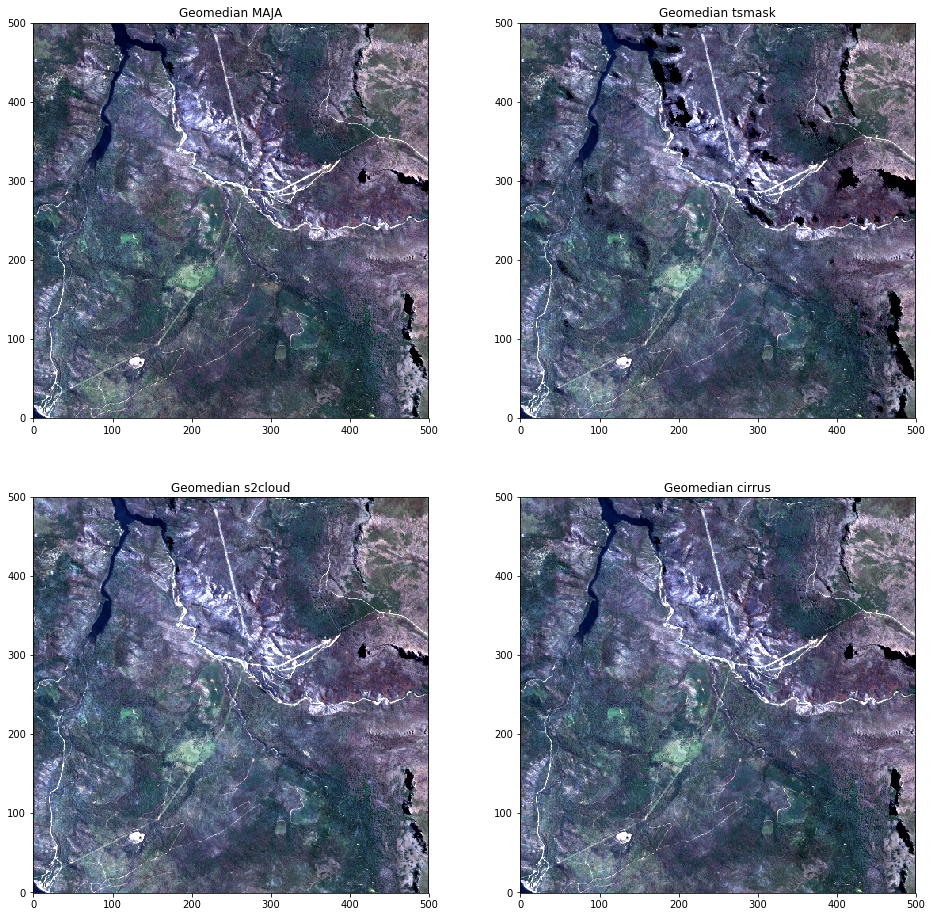

In [266]:
ncol=2
nrow=2
f = plt.figure(figsize=(16,16/ncol*nrow))
gs = gridspec.GridSpec(nrow, ncol, figure=f)
for i, median_image in enumerate([median_image_maja, median_image_tsmask, median_image_s2cloud, median_image_cirrus]):
    ax = f.add_subplot(gs[i])
    ax.imshow(RGB_plot(median_image[true_rgb].to_array(),*true_img[1:])[0],origin='lower')
    ax.set_title(median_image.attrs['name'])

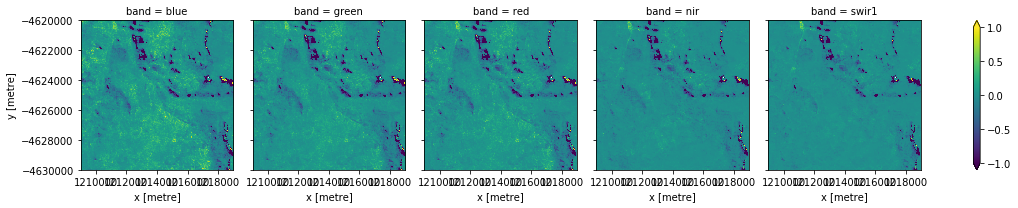

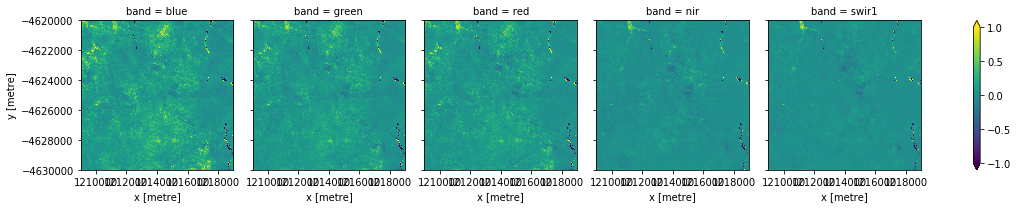

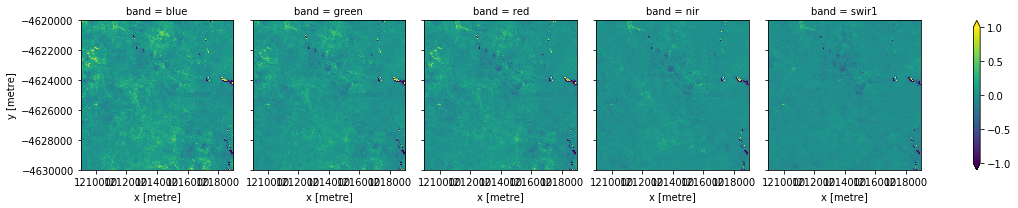

In [247]:
((median_image_tsmask-median_image_maja)/median_image_maja).to_array(dim='band').plot.imshow(col='band',col_wrap=5, vmin=-1, vmax=1)
((median_image_s2cloud-median_image_maja)/median_image_maja).to_array(dim='band').plot.imshow(col='band',col_wrap=5, vmin=-1, vmax=1)
((median_image_cirrus-median_image_maja)/median_image_maja).to_array(dim='band').plot.imshow(col='band',col_wrap=5, vmin=-1, vmax=1)

In [263]:
print(np.abs((median_image_tsmask-median_image_maja)/median_image_maja).where(median_image_maja>0).mean(skipna=True))
print(np.abs((median_image_s2cloud-median_image_maja)/median_image_maja).where(median_image_maja>0).mean(skipna=True))
print(np.abs((median_image_cirrus-median_image_maja)/median_image_maja).where(median_image_maja>0).mean(skipna=True))

<xarray.Dataset>
Dimensions:  ()
Data variables:
    blue     float32 0.24221718
    green    float32 0.18233024
    red      float32 0.18068713
    nir      float32 0.09003334
    swir1    float32 0.07883255
<xarray.Dataset>
Dimensions:  ()
Data variables:
    blue     float32 0.12936345
    green    float32 0.091800265
    red      float32 0.093485035
    nir      float32 0.035707507
    swir1    float32 0.041041642
<xarray.Dataset>
Dimensions:  ()
Data variables:
    blue     float32 0.13667214
    green    float32 0.096962005
    red      float32 0.08743634
    nir      float32 0.04266214
    swir1    float32 0.04500569


In [264]:
print(np.abs((median_image_tsmask-median_image_maja)/median_image_maja).where(median_image_maja>0).max())
print(np.abs((median_image_s2cloud-median_image_maja)/median_image_maja).where(median_image_maja>0).max())
print(np.abs((median_image_cirrus-median_image_maja)/median_image_maja).where(median_image_maja>0).max())

<xarray.Dataset>
Dimensions:  ()
Data variables:
    blue     float64 5.195e+03
    green    float64 1.378e+03
    red      float64 1.732e+03
    nir      float64 188.8
    swir1    float64 1.031e+03
<xarray.Dataset>
Dimensions:  ()
Data variables:
    blue     float64 375.7
    green    float64 79.37
    red      float64 825.6
    nir      float64 295.1
    swir1    float64 1.417e+03
<xarray.Dataset>
Dimensions:  ()
Data variables:
    blue     float64 1.79e+03
    green    float64 1.378e+03
    red      float64 1.732e+03
    nir      float64 96.1
    swir1    float64 1.175e+03
